# Cifar Image Classification using PyTorch:
##### Convolutional Neural Networks and Artificial Neural Networks

#### imports 

In [2]:
## torch imports and more...
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset,DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd

Downloading the data:

In [3]:

training_data = torchvision.datasets.CIFAR10(root='.',train=True,transform=transforms.ToTensor(),download=True)
testing_data = torchvision.datasets.CIFAR10(root='.',train=False,transform=transforms.ToTensor(),download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting .\cifar-10-python.tar.gz to .
Files already downloaded and verified


Inspecting the data:

In [4]:
training_data.data.shape,testing_data.data.shape,training_data.targets[:5],testing_data.targets[:5]

((50000, 32, 32, 3), (10000, 32, 32, 3), [6, 9, 9, 4, 1], [3, 8, 8, 0, 6])

In [5]:
num_classes=10
training_data_loader =DataLoader(dataset=training_data,batch_size=256, shuffle=True)
testing_data_loader = DataLoader(dataset=testing_data, batch_size=256,shuffle=False)

Creating a CNN model.
#####  CNN:

In [6]:
class simple_convolutional_model(nn.Module):
    def __init__(self,num_classes):
        super(simple_convolutional_model,self).__init__()
        ## layers
        self.convolution1=nn.Conv2d(3,32,kernel_size=3,stride=2)
        #self.convbatchnorm1=nn.BatchNorm2d(32)
        self.convolution2=nn.Conv2d(32,64,kernel_size=3,stride=2)
        #self.convbatchnorm2=nn.BatchNorm2d(64)   
        self.convolution3=nn.Conv2d(64,128,kernel_size=3,stride=2)
        self.convbatchnorm3=nn.BatchNorm2d(128)
        self.fully_connected_1=nn.Linear(1152,600)
        self.fully_connected_final=nn.Linear(600,num_classes)
        ## FORWARD
    def forward(self,x):
        x=F.relu((self.convolution1(x)))
        x=F.relu((self.convolution2(x)))
        x=F.relu(self.convbatchnorm3(self.convolution3(x)))
        x=x.view(-1,1152)
        x=F.dropout(x,p=0.45)
        x=F.relu(self.fully_connected_1(x))
        x=F.dropout(x,p=0.5)
        x=self.fully_connected_final(x)
        return x
##  creating the simple conv model
simple_conv_model=simple_convolutional_model(num_classes)
### using cuda to use the gpu:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
### if the output is "cuda:0" it means we're using GPU!!!!!
print(device)
simple_conv_model.to(device)
### Setting up the loss criterion and the optimizer
simple_conv_optimizer=torch.optim.Adam(simple_conv_model.parameters())
simple_conv_criterion=nn.CrossEntropyLoss()
'''
setting up the training function:

'''
## function to do the training
def training_function(mdl, crit, optim, TrainingDataLoader, TestingDataLoader, epochs=20):
  ### Creating empty arrays to save the history of the training 
  ### and testing losses
    history_of_training_losses = np.zeros(epochs)
    history_of_testing_losses = np.zeros(epochs)
    for epc in range(epochs):
        mdl.train()
        current_training_loss = []
        for x, y in TrainingDataLoader:
      ### WE have to do this step to speed up the process
      ### basically the data and the model both have to be on the GPU for
      ## cuda to work...
            x, y = x.to(device), y.to(device)
      ## we also have to always empty the gradients, as 
      ## Pytorch saves the previous ones every time
            optim.zero_grad()
      ## getting predictions
            y_hat = mdl(x)
            loss = crit(y_hat, y)
      #### Backprop and optimization step
            loss.backward()
            optim.step()
            current_training_loss.append(loss.item())
    # Get train loss and test loss
        current_training_loss = np.mean(current_training_loss)
        mdl.eval()
        current_testing_loss = []
        for x, y in TestingDataLoader:
            x, y = x.to(device), y.to(device)
            y_hat = mdl(x)
            loss = crit(y_hat,y)
            current_testing_loss.append(loss.item())
        current_testing_loss = np.mean(current_testing_loss)
    ### Keeping track of all of the losses
        history_of_training_losses[epc] = current_training_loss
        history_of_testing_losses[epc] = current_testing_loss
        print('epoch: ',epc+1)
    return history_of_training_losses, history_of_testing_losses

cuda:0


Running the Model, getting the output:
Let's train our model for 20 epochs:

In [7]:
TrainHistoryLoss, TestHistoryLoss =training_function(simple_conv_model, simple_conv_criterion, simple_conv_optimizer, training_data_loader, testing_data_loader, epochs=20)

epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
epoch:  10
epoch:  11
epoch:  12
epoch:  13
epoch:  14
epoch:  15
epoch:  16
epoch:  17
epoch:  18
epoch:  19
epoch:  20


Analysis of the Convolutional model:
Plotting the losses:

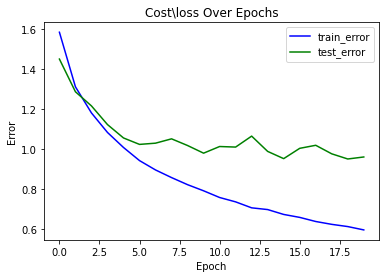

In [8]:
plt.plot(TrainHistoryLoss,color='b')
plt.plot(TestHistoryLoss,color='g')
plt.title("Cost\loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend(['train_error','test_error'])

For the accuracy, I will create a function that will take the model as input and then output the accuracy
that way we save time and code when inspecting the ANN model:


In [9]:
def calculate_model_accuracy(model=simple_conv_model):
    ### Accuracy evaluations of our simple convolutional model.
    model.eval()
    rights,total = 0,0
    for x, y in training_data_loader:
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        z, preds = torch.max(y_hat, 1)
        rights += (preds == y).sum().item()
        total += y.shape[0]
    training_accuracy = rights / total
    ### doing the same for the test set...
    rights,total=0,0
    for x, y in testing_data_loader:
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        z, preds = torch.max(y_hat, 1)
        rights += (preds == y).sum().item()
        total += y.shape[0]
    testing_accuracy = rights / total
    print("Training Accuracy",training_accuracy,"Testing Accuracy",testing_accuracy)  
    
calculate_model_accuracy(simple_conv_model)

Training Accuracy 0.7991 Testing Accuracy 0.6881


We can see that the accuracy is pretty decent, better than guessing.

Creating a function to create a confusion matrix. By default will work for the Convolutional model
if we input the ann model later, it should work.


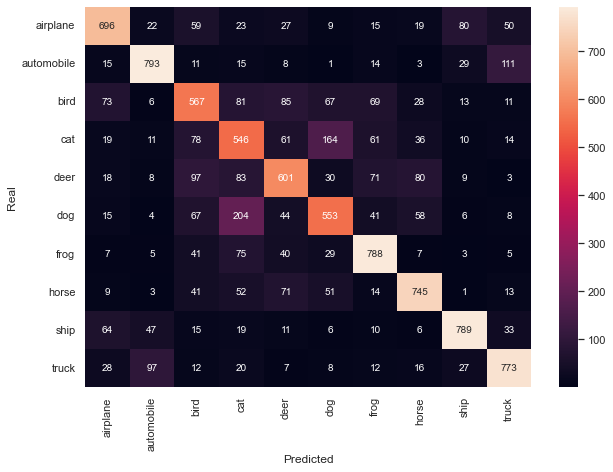

In [10]:
## Let's use the testing_data_loader in order to create a confusion matrix.
### BY DEFAULT THIS WILL WORK FOR THE simple_conv_model, if we enter the ANN model(which we will create later...)
#, it will work also.
def create_confusion_matrix(X=testing_data.data,Y=np.array(testing_data.targets),model=simple_conv_model,testing_data_loader=testing_data_loader):  
    labels=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
    Y_PRED = np.array([])
    for x, y in testing_data_loader:
        x,y = x.to(device), y.to(device)
        y_hat = model(x)
        Z, preds = torch.max(y_hat, 1)
        Y_PRED = np.concatenate((Y_PRED, preds.cpu().numpy()))
    cm = confusion_matrix(Y, Y_PRED)
    df_cm = pd.DataFrame(cm,labels,labels)
    plt.figure(figsize=(10,7))
    sn.set(font_scale=1)
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 10},fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Real')
    plt.show()
###############
### Creating the confusion matrix
'''
USING THE FUNCTION, NOTE THAT NO INPUT IS NEEDED RIGHT NOW,
BUT WHEN WE WILL INSPECT THE 
ANN WE WILL
HAVE TO ENTER THE FC MODEL
'''
create_confusion_matrix()

We can see problems with ship and airplane, automobile and truck, cat and dog, deer and horse, etc. .


#####  The ANN Model:

For the simple ann model I will use basically the same code I used for the cnn
but this time I will switch the convolutional layers with simple fully connected layers.

In [11]:
class simple_fullyconnected_model(nn.Module):
    def __init__(self,num_classes):
        super(simple_fullyconnected_model,self).__init__()
    ## layers
        self.fullyconnected1=nn.Linear(3072,50)
        self.fullyconnected2=nn.Linear(50,100)  
        self.fullyconnected3=nn.Linear(100,100)
        self.connectedbatchnorm3=nn.BatchNorm1d(100)
        self.fullyconnected4=nn.Linear(100,50)
        self.fully_connected_final=nn.Linear(50,num_classes)
    ## FORWARD
    def forward(self,x):
        x = x.view(x.size(0), -1)
        x=F.relu((self.fullyconnected1(x)))
        x=F.dropout(x,p=0.1)
        x=F.relu((self.fullyconnected2(x)))
        x=F.dropout(x,p=0.2)
        x=F.relu(self.connectedbatchnorm3(self.fullyconnected3(x)))
        x=F.dropout(x,p=0.3)
        x=F.relu(self.fullyconnected4(x))
        x=F.dropout(x,p=0.4)
        x=self.fully_connected_final(x)
        return x

##  creating the simple fully connected modle
simple_fc_model=simple_fullyconnected_model(num_classes)
### using cuda to use the gpu:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
### if the output is "cuda:0" it means we're using GPU!!!!!
print(device)
simple_fc_model.to(device)
### Setting up the loss criterion and the optimizer
simple_fc_optimizer=torch.optim.Adam(simple_fc_model.parameters())
simple_fc_criterion=nn.CrossEntropyLoss()

## training the model
TrainHistoryLoss, TestHistoryLoss =training_function(simple_fc_model, simple_fc_criterion, simple_fc_optimizer, training_data_loader, testing_data_loader, epochs=20)

cuda:0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
epoch:  10
epoch:  11
epoch:  12
epoch:  13
epoch:  14
epoch:  15
epoch:  16
epoch:  17
epoch:  18
epoch:  19
epoch:  20


Analysis of the ANN Model:


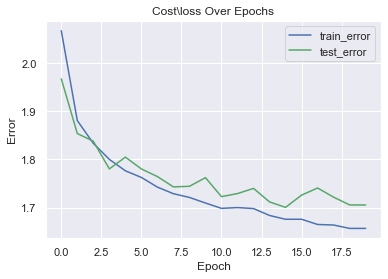

In [12]:
plt.plot(TrainHistoryLoss,color='b')
plt.plot(TestHistoryLoss,color='g')
plt.title("Cost\loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend(['train_error','test_error'])

Let's get the ANN Model accuracies:

In [13]:
calculate_model_accuracy(simple_fc_model)

Training Accuracy 0.40632 Testing Accuracy 0.3956


Horrible accuracies when compared to the CNN model.


Confusion Matrix:

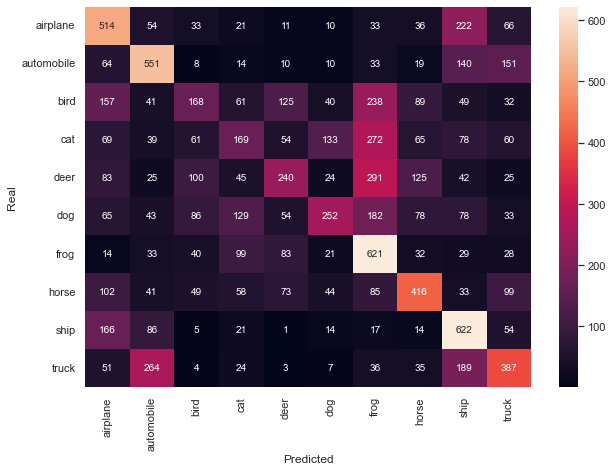

In [14]:
create_confusion_matrix(model=simple_fc_model)

we can see that its pretty bad.  by seeing that this matrix is more "colorful" than the cnn's matrix, we can conclude again that this model is doing a pretty bad job.
we can see that the model has a really bad time with airplanes and ships, automobiles and trucks, automobiles and ships, dogs and ships, cats and ships, birds and airplanes... etc... etc...
In conclusion, from this simple experiemnt it is easy to see that Convolutional layers are very effective when using image data